# NLP text classification -- product classification

### Problem Statement: classify products by sub-category using product names

In [ ]:
import pandas as pd
import numpy as np
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
# import plotly.express as px
# import plotly.graph_objs as go
import re
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

import gensim
from gensim.models.word2vec import Word2Vec, KeyedVectors
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Embedding, Dense, Dropout, SpatialDropout1D

In [ ]:
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [ ]:
pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/superstore_products_new.csv', usecols=['product_name','category'])

In [ ]:
df.loc[df['product_name'].duplicated()]

,category,product_name


[]

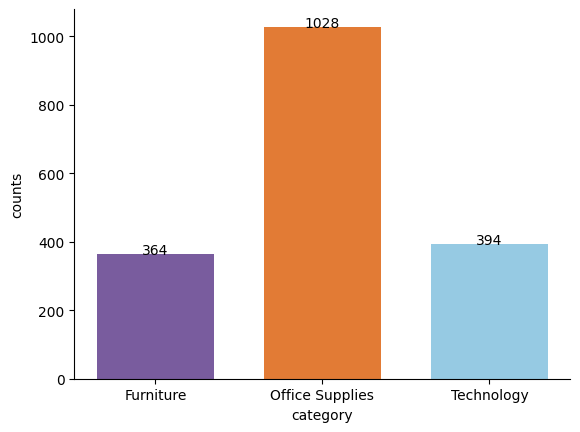

In [ ]:
category_counts = df.groupby(['category']).size().to_frame().rename(columns={0:'counts'})
sns.barplot(category_counts, y='counts', x='category', hue='category', palette=['#7851A9','#FF7518', '#89CFF0'], width=0.7)
for i, c in enumerate(category_counts['counts']):
  plt.text(i, c, str(c), ha='center')
sns.despine()
plt.plot()

In [ ]:
def prep_tokenised(text:str, token:bool=True)->str:
  text = re.sub(r"[^\w\s_]", ' ', text)
  text = ' '.join([word for word in text.split() if word not in stopwords.words('english') and len(word)>2])
  if token:
    return word_tokenize(text.lower())
  else:
    return text.lower()

In [ ]:
df['prep_product_name'] = df['product_name'].apply(lambda txt: prep_tokenised(txt, token=False))
df['tokens'] = df['product_name'].apply(prep_tokenised)

In [ ]:
df['category'] = df['category'].apply(str.lower)

In [ ]:
len_list = [len(tk) for tk in df['tokens']]
print(max(len_list), sum(len_list))

16 9107


In [ ]:
tagged_doc = df.apply(lambda dt: TaggedDocument(words=dt['tokens'], tags=dt['category']), axis=1)

# tagged_doc =  TaggedDocument(words=df['tokens'].values, tags=df['category'].values)
tagged_doc.values

array([TaggedDocument(words=['while', 'were', 'out', 'message', 'book', 'one', 'form', 'per', 'page'], tags='office supplies'),
       TaggedDocument(words=['gummed', 'flap', 'white', 'envelopes', '100', 'box'], tags='office supplies'),
       TaggedDocument(words=['self', 'seal', 'white', 'envelopes'], tags='office supplies'),
       ...,
       TaggedDocument(words=['zebra', 'zazzle', 'fluorescent', 'highlighters'], tags='office supplies'),
       TaggedDocument(words=['zebra', 'zm400', 'thermal', 'label', 'printer'], tags='technology'),
       TaggedDocument(words=['zipper', 'ring', 'binder', 'pockets'], tags='office supplies')],
      dtype=object)

In [ ]:
d2v_model = Doc2Vec(tagged_doc, vector_size=10, window=5,
                    min_count=1, dm=1, epochs=20)
#d2v_model.build_vocab([x for x in tagged_doc])

In [ ]:
print(len(d2v_model.wv.index_to_key), d2v_model.dv.vectors.shape)

2369 (16, 10)


In [ ]:
d2v_model.dv.vectors

array([[ 2.8335567 ,  4.338798  , -7.3684916 , -4.5740376 ,  1.7193834 ,
         4.973811  , -7.5164557 , -1.1003654 , -9.341978  , -4.830738  ],
       [-0.5726626 ,  2.792707  , -2.372222  , -2.905202  ,  3.205652  ,
        -4.7593455 ,  5.429566  , -3.3197465 ,  4.511555  , -1.6777605 ],
       [-0.63866746,  2.7723432 , -2.3861637 , -2.8475375 ,  3.2944682 ,
        -4.7531877 ,  5.3245406 , -3.5115366 ,  4.655933  , -1.7344135 ],
       [ 2.018305  ,  3.3090367 , -3.3106127 , -2.688803  ,  2.3851843 ,
         2.4413471 , -1.653393  , -1.3188919 , -4.5143037 , -2.6675005 ],
       [ 0.3043774 ,  3.8315187 , -6.3115106 , -4.97548   ,  2.5495906 ,
        -2.1719303 , -0.3648101 , -3.2478156 , -0.10587405, -3.8892698 ],
       [ 1.0127903 ,  2.0825403 ,  0.71207386, -0.69292337,  3.0923607 ,
        -0.03342357,  4.1278467 , -1.3828375 ,  0.23085664, -0.43058622],
       [ 2.0971382 ,  4.259782  ,  1.6004419 , -1.2973402 ,  6.2457924 ,
        -0.28703588,  8.338882  , -2.8181138 

In [ ]:
embedding_vec = np.zeros((len(d2v_model.wv.index_to_key)+ 1, 10))
for i, v in enumerate(d2v_model.dv.vectors):
    while i in v <= 1000:
      embedding_vec[i]=v

# LSTM

In [ ]:
max_word_num = 20000
max_seq = 30

In [ ]:
tokeniser = Tokenizer(num_words=max_word_num)
tokeniser.fit_on_texts(df['prep_product_name'].values)

X = tokeniser.texts_to_sequences(df['prep_product_name'].values)
X = pad_sequences(X, maxlen=max_seq, truncating='post')

In [ ]:
print('unique tokens:',len(tokeniser.word_index))
print('padded shape:', X.shape)

unique tokens: 2369
padded shape: (1786, 30)


In [ ]:
Y = pd.get_dummies(df['category']).values.astype(int)
# Y = tf.keras.utils.to_categorical(df['category'], 3)
Y

array([[0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       ...,
       [0, 1, 0],
       [0, 0, 1],
       [0, 1, 0]])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2, random_state = 100)

In [ ]:
model = Sequential()
model.add(Embedding(2370, 10, input_length=X.shape[1], weights=embedding_vec, trainable=True))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(3, activation='softmax'))
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_6 (Embedding)              │ ?                           │          23,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ spatial_dropout1d_3                  │ ?                           │     0 (unbuilt) │
│ (SpatialDropout1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,700 (92.58 KB)

 Trainable params: 23,700 (92.58 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=2)

Epoch 1/50
45/45 - 3s - 71ms/step - accuracy: 0.5665 - loss: 0.9958
Epoch 2/50
45/45 - 1s - 23ms/step - accuracy: 0.5742 - loss: 0.9197
Epoch 3/50
45/45 - 1s - 26ms/step - accuracy: 0.6919 - loss: 0.7000
Epoch 4/50
45/45 - 2s - 38ms/step - accuracy: 0.8683 - loss: 0.3827
Epoch 5/50
45/45 - 1s - 27ms/step - accuracy: 0.9447 - loss: 0.1837
Epoch 6/50
45/45 - 1s - 14ms/step - accuracy: 0.9762 - loss: 0.0841
Epoch 7/50
45/45 - 1s - 13ms/step - accuracy: 0.9923 - loss: 0.0511
Epoch 8/50
45/45 - 1s - 13ms/step - accuracy: 0.9958 - loss: 0.0283
Epoch 9/50
45/45 - 1s - 14ms/step - accuracy: 0.9944 - loss: 0.0221
Epoch 10/50
45/45 - 1s - 13ms/step - accuracy: 0.9979 - loss: 0.0142
Epoch 11/50
45/45 - 1s - 14ms/step - accuracy: 0.9986 - loss: 0.0093
Epoch 12/50
45/45 - 1s - 13ms/step - accuracy: 0.9986 - loss: 0.0120
Epoch 13/50
45/45 - 1s - 14ms/step - accuracy: 1.0000 - loss: 0.0065
Epoch 14/50
45/45 - 1s - 14ms/step - accuracy: 0.9993 - loss: 0.0062
Epoch 15/50
45/45 - 1s - 13ms/step - accura

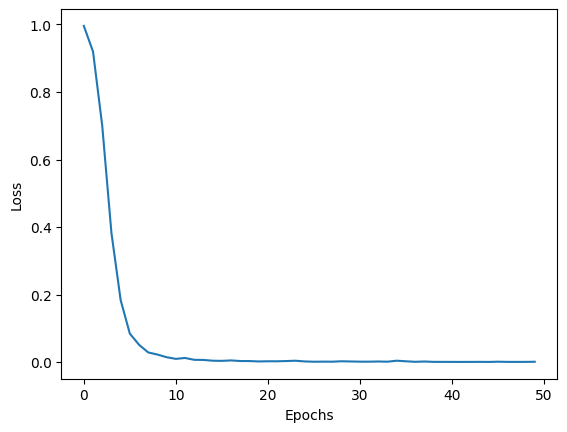

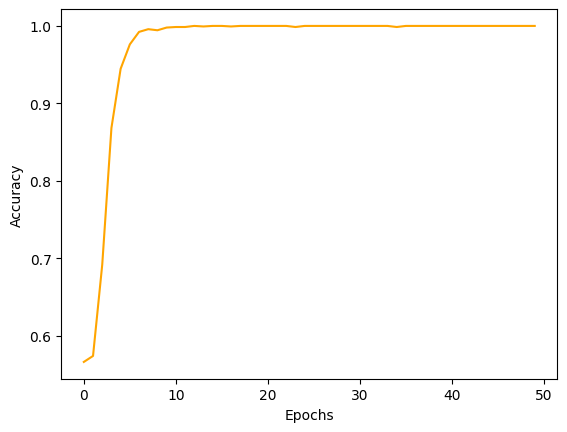

In [ ]:
plt.plot(history.history['loss'])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

plt.plot(history.history['accuracy'], color='orange')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [97]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(-1)

y_test_class = np.argmax(y_test, axis=1)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


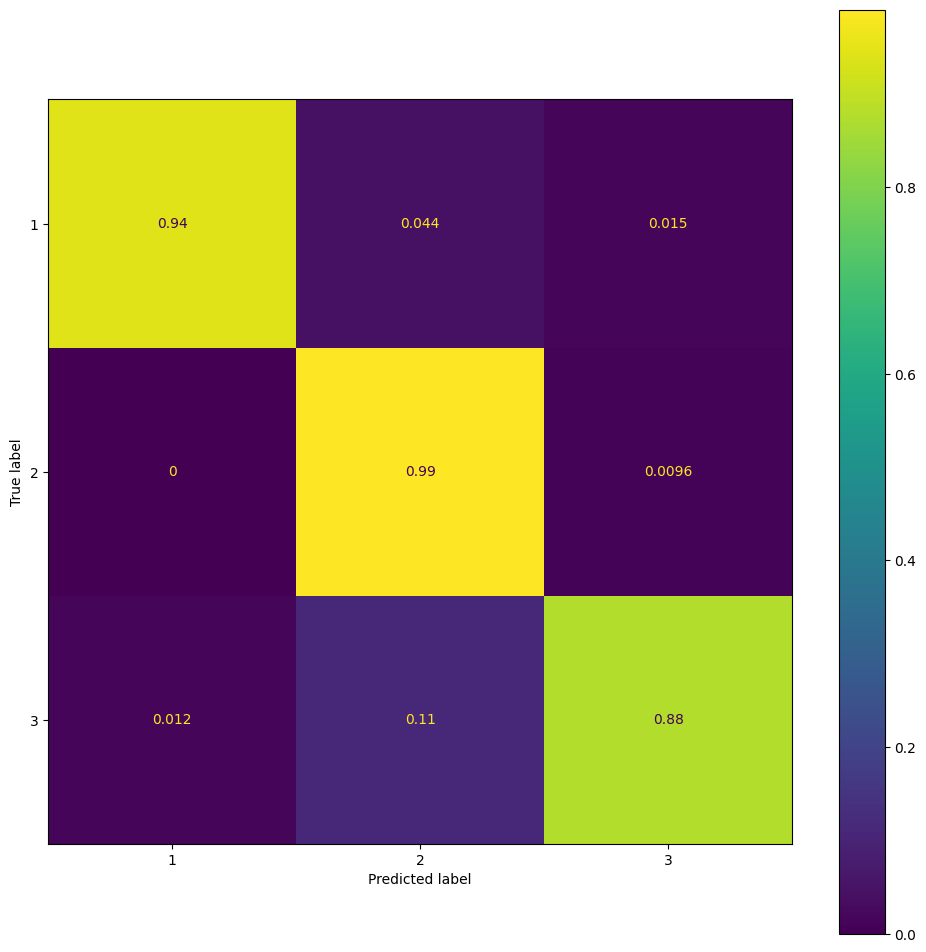

In [98]:
cf = confusion_matrix(y_test_class, y_pred, normalize='true')
fig, ax = plt.subplots(figsize=(12, 12))
disp = ConfusionMatrixDisplay(cf, display_labels=[1,2,3])
disp.plot(ax=ax)
plt.show()